In [1]:
import numpy as np
import igraph
import scipy
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import networkx as nx
import anndata as ad
import phate

In [2]:
counts_sanger = pd.read_csv('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/data/pk10xIDC_github/pk10xIDC_counts.csv')
PC_file = pd.read_csv('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/data/pk10xIDC_github/pk10xIDC_pheno.csv')

In [3]:
# transpose matrix
counts_sanger = counts_sanger.transpose()

In [4]:
# set the first row to a column
counts_sanger.columns = counts_sanger.iloc[0]

In [5]:
# drop that row
counts_sanger = counts_sanger.drop(counts_sanger.index[0])

In [6]:
# create row names (index) and column names (gene) names
counts_sanger.index.names = ['Cells']
counts_sanger.columns.names = ['Genes']

In [7]:
# initalize dictionary
gff_dict = {new_list: [] for new_list in counts_sanger.columns}

In [8]:
with open('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/metadata/Sanger_genome/PlasmoDB-61_PknowlesiH.gff') as annotation_f:
    for gff_line in annotation_f:
        clean_gff_line = gff_line.strip()
        # don't forget about header (##)
        if '##' not in clean_gff_line and 'RNA' in clean_gff_line:
            clean_gff_list = clean_gff_line.split('\t')
            # Store the gene ID in the Parent entry in each accession
            ID = clean_gff_list[8].split(';')[1][7:]
            #print(ID)
            # only store genes in the file and with an empty list
            if ID in gff_dict.keys() and gff_dict[ID] == []:
                # Find the index that begins the gene name
                start_of_name = gff_line.find('description') + 12
                #Store the gene name in the variable description
                description = gff_line[start_of_name:].split(';')[0]
                # If there is a space, replace it with an underscore
                if ' ' in description:
                    # Replace the space with an underscore
                    name_nowt = description.replace(' ', '_')
                    # Replace the ACII code for a comma with a blank string and replace - with an underscore
                    if '%2C' in description or '-' in description or '/' in description or '(' in description or ')' in description or '[' in description or ']' in description or "'" in description or "+" in description:
                        name_nocomma = name_nowt.replace('%2C', '')
                        name_nounder = name_nocomma.replace('-', '_')
                        name_nopara = name_nounder.replace('(', '_')
                        name_nopara2 = name_nopara.replace(')', '_')
                        name_nobracket = name_nopara2.replace('[', '_')
                        name_nobracket2 = name_nobracket.replace(']', '_')
                        name_noapo = name_nobracket2.replace("'", '_')
                        name_noplus = name_noapo.replace("+", "plus")
                        name = name_noplus.replace('/', '_')
                    # If the name does not have those characters, then store name
                    else:
                        name = name_nowt
                gff_dict[ID].append(name)

In [9]:
gene_IDs = []
for a in counts_sanger.columns:
     gene_IDs.append(
        {
            'PK_ID': a,
            'Gene': ''.join(gff_dict[a])
        }
    )
gene_IDs = pd.DataFrame(gene_IDs)

In [10]:
# load the cell by gene matrix
adata = sc.AnnData(counts_sanger,
    counts_sanger.index.to_frame(),
    counts_sanger.columns.to_frame())

/var/folders/b3/_d0b62ts645bnlhb2xdb86xm0000gn/T/ipykernel_89555/1254234500.py:2: FutureWarning: X.dtype being converted to np.float32 from object. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(counts_sanger,


In [11]:
# add
adata.var['gene_symbols'] = gene_IDs['Gene'].tolist()

In [12]:
adata.var_names = adata.var['gene_symbols']

In [13]:
# make names unique
adata.var_names_make_unique(join='')
adata.var_names
adata.obs["cell_type"] = pd.Categorical(PC_file.bulk.values)

In [14]:
# log normalize
sc.pp.log1p(adata)

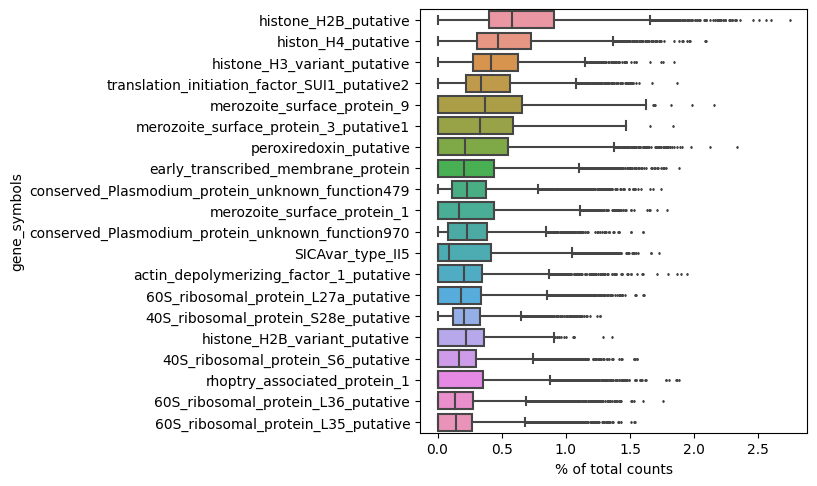

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20, )

/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


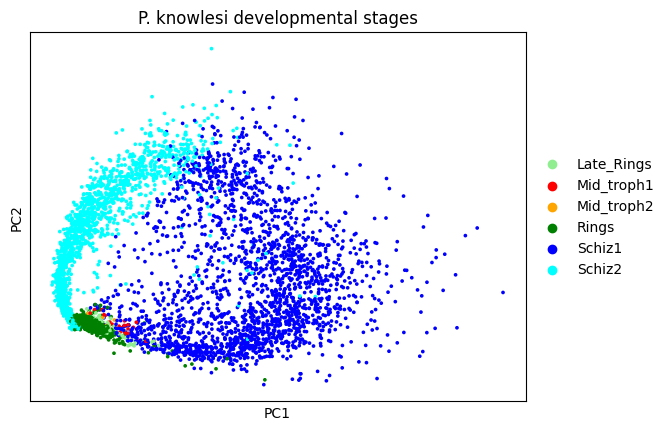

In [42]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata,
          color="cell_type",
          save='.png',
          title = 'P. knowlesi developmental stages',
          palette={
              "Rings": "green",
              "Late_Rings": "lightgreen",
              "Mid_troph1": "red",
              "Mid_troph2": "orange",
              "Schiz1": "blue",
              "Schiz2": "cyan"
    })

2023-04-29 23:18:40.265543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


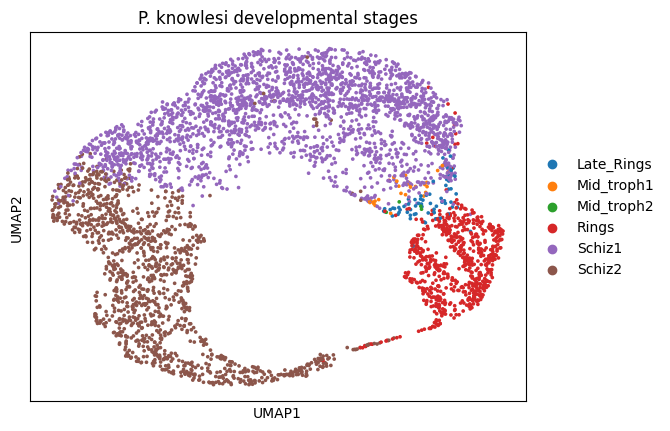

In [17]:
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(adata)
sc.pl.umap(adata,color="cell_type",save='Pk.png',title = 'P. knowlesi developmental stages')

In [18]:
# phate_op = phate.PHATE(n_components=2, knn=10, decay = 40, n_jobs = 8)
# X_phate = phate_op.fit_transform(adata)
# adata.obsm['X_phate'] = X_phate

In [19]:
# sc.pl.scatter(adata, basis = 'phate', color = 'cell_type', size = 100)

In [30]:
# dense node features matrix
#log_trans_node_feat = np.array(adata.X)
log_trans_node_feat = np.array(adata.obsm['X_pca'])
# dense adjacency matrix
#adj_COO = adata.obsp['connectivities'].A
adj_COO = adata.obsp['connectivities']
# dense edge features matrix
#edge_feat = adata.obsp['distances'].A
# labels
labels = np.asarray(PC_file.bulk.values)

In [31]:
#Graph = spektral.data.Graph(x=log_trans_node_feat, a=adj_COO, e=edge_feat, y=labels)

In [32]:
import torch
import networkx as nx
import spektral
from spektral.data import Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from spektral.layers import GCNConv

class MyDataset(Dataset):
    """
    A dataset of one graph from the MCA.
    """
    def __init__(self, nodes, feats, **kwargs):
        self.nodes = nodes
        self.feats = feats

        super().__init__(**kwargs)
    def read(self):
        output = []
        A = adj_COO
        Y = PC_file.bulk.values
        le = OneHotEncoder()
        YY = le.fit_transform(Y.reshape(-1,1))

        output.append(
            spektral.data.Graph(x=self.feats.astype("float32"),
                                a=A.astype("float32"),
                                y=YY.astype("float32").todense()))
        return output

n_nodes = labels.shape[0]
dataset = MyDataset(nodes = np.array(list(range(0,n_nodes))),
                    feats = log_trans_node_feat,
                    transforms=[LayerPreprocess(GCNConv)])
                    #transforms=[LayerPreprocess(GCNConv), AdjToSpTensor()])

In [33]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
# had to use torch 1.7.1!!
#import torch
train_ratio = 0.7
#validation_ratio = 0.1
test_ratio = 0.30

# # train is 80% of data
# mask_tr = np.random.rand(len(labels)) < train_ratio
# train = labels[mask_tr]
#
# ratio_remaining = 1 - train_ratio
# ratio_val_adjusted = validation_ratio / ratio_remaining
#
# # test is 10% of data
# # validataion is 10% of initial dataset
# intermediate = labels[~mask_tr]
# mask_test = np.random.rand(len(intermediate)) < 1 - ratio_val_adjusted
# test = intermediate[mask_test]
# valid = intermediate[~mask_test]

#groups = np.random.choice([0,1,2], p=[train_ratio, validation_ratio, test_ratio], size=labels.shape)
# calculate the number of nodes
n_nodes = labels.shape[0]
# create a np array of every node from 1 to max number of nodes
nodes = np.array(list(range(0,n_nodes)))

# split data into test first
X_train, X_test, y_train, y_test = train_test_split(pd.Series(nodes),
                                                    pd.Series(labels),
                                                    test_size=test_ratio,
                                                    random_state=42)

# # adjust
# ratio_remaining = 1 - train_ratio
# ratio_val_adjusted = validation_ratio / ratio_remaining
#
# # Produces train and val masks.
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=ratio_val_adjusted)

train_mask = torch.zeros(n_nodes, dtype=torch.float32)
test_mask = torch.zeros(n_nodes, dtype=torch.float32)
#val_mask = torch.zeros(n_nodes, dtype=torch.float32)
train_mask[X_train.index] = 1
test_mask[X_test.index] = 1
#val_mask[X_val.index] = 1

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from spektral.data.loaders import SingleLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv
from spektral.models.gcn import GCN
from spektral.transforms import LayerPreprocess

learning_rate = 1e-2
seed = 0
epochs = 200
patience = 10

# We convert the binary masks to sample weights so that we can compute the
# average loss over the nodes (following original implementation by
# Kipf & Welling)
def mask_to_weights(mask):
    return mask.type(torch.float32) / np.count_nonzero(mask)

weights_tr, weights_te = (mask_to_weights(mask) for mask in (train_mask, test_mask))

# instantiate the model
model = GCN(n_labels=dataset.n_labels)

model.compile(
    optimizer=Adam(learning_rate),
    loss=CategoricalCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)

In [35]:
from spektral.data.loaders import SingleLoader

# Train model
loader_tr = SingleLoader(dataset, sample_weights=weights_tr.numpy())

model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

# Evaluate model
loader_te = SingleLoader(dataset, sample_weights=weights_te.numpy())

train_results = model.evaluate(loader_tr.load(), steps=loader_tr.steps_per_epoch)
test_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)

print('#' * 50)
print('Train Accuracy: %s' %train_results[1] )
print('Test Accuracy: %s' % test_results[1])
print('#' * 50)

Epoch 1/200
1/1 [==============================] - 0s 397ms/step - loss: 3.0340 - acc: 0.1170
Epoch 2/200
1/1 [==============================] - 0s 14ms/step - loss: 2.6969 - acc: 0.1686
Epoch 3/200
1/1 [==============================] - 0s 12ms/step - loss: 2.2661 - acc: 0.2462
Epoch 4/200
1/1 [==============================] - 0s 12ms/step - loss: 1.9402 - acc: 0.3386
Epoch 5/200
1/1 [==============================] - 0s 12ms/step - loss: 1.6502 - acc: 0.4317
Epoch 6/200
1/1 [==============================] - 0s 12ms/step - loss: 1.4520 - acc: 0.4934
Epoch 7/200
1/1 [==============================] - 0s 12ms/step - loss: 1.2443 - acc: 0.5514
Epoch 8/200
1/1 [==============================] - 0s 12ms/step - loss: 1.0928 - acc: 0.6007
Epoch 9/200
1/1 [==============================] - 0s 13ms/step - loss: 0.9968 - acc: 0.6452
Epoch 10/200
1/1 [==============================] - 0s 12ms/step - loss: 0.8516 - acc: 0.6809
Epoch 11/200
1/1 [==============================] - 0s 12ms/step - l

In [36]:
test_train = []
# create a label with a for loop to create a series, which is cells in one column and in test in another column (T/F)
for x, y in enumerate(counts_sanger.index.tolist()):
    if x in X_test.index.tolist():
        test_train.append([y,'Test'])
    else:
        test_train.append([y,'Train'])
test_train = pd.DataFrame(test_train)
test_train.columns = ['Cells','test_train']
cells_in_test = test_train.loc[test_train['test_train'] == 'Test']

# add to adata object
adata.obs['test_train'] = "Train"
adata.obs.loc[cells_in_test['Cells'],'test_train'] = 'Test'

In [37]:
# use model.predict here: https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-predict-new-samples-with-your-keras-model.md
predictions = model.predict(loader_te.load(),steps=loader_te.steps_per_epoch)
# get the highest probability for each class
classes = np.argmax(predictions, axis = 1)
labels_class = {0: 'Late_Rings', 1: 'Mid_troph1', 2:'Mid_troph2',3:'Rings',4:'Schiz1',5:'Schiz2'}
str_class = []
for i in classes:
    str_class.append(labels_class[i])

# get the original classes
#original_class = pd.factorize(PC_file.bulk.values.tolist(),sort=True)
original_class = np.array(PC_file.bulk.values.tolist())

1/1 [==============================] - 0s 31ms/step


In [38]:
str_class = np.array(str_class)
# subset based on test indices
predictions_test = str_class[X_test.index.tolist()]
original_class_test = original_class[X_test.index.tolist()]

In [39]:
# calculate F1 score: https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score
from sklearn.metrics import classification_report
print(classification_report(original_class_test, predictions_test,zero_division=0))

              precision    recall  f1-score   support

  Late_Rings       0.50      0.68      0.58        19
  Mid_troph1       0.00      0.00      0.00         9
  Mid_troph2       0.00      0.00      0.00         1
       Rings       0.97      0.96      0.97       200
      Schiz1       0.97      0.98      0.97       664
      Schiz2       0.98      0.97      0.98       379

    accuracy                           0.96      1272
   macro avg       0.57      0.60      0.58      1272
weighted avg       0.96      0.96      0.96      1272



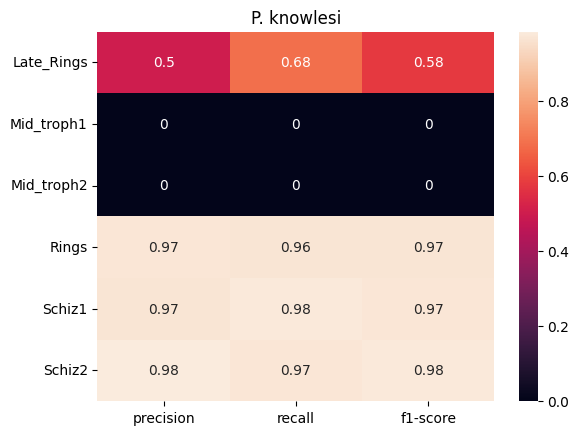

In [50]:
import seaborn as sns
report = classification_report(original_class_test, predictions_test,zero_division=0,output_dict=True)
report_df = pd.DataFrame.from_dict(report)
report_df.to_csv('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/scripts/analysis_script/figures/Pk_report.csv')
report_heat = sns.heatmap(report_df.iloc[:-1, :-3].T,
            annot=True)
report_heat.set_title('P. knowlesi')
report_heat_fig = report_heat.get_figure()
report_heat_fig.savefig("figures/Pk_prediction_table.png", dpi=400, bbox_inches = "tight")

/var/folders/b3/_d0b62ts645bnlhb2xdb86xm0000gn/T/ipykernel_89555/3400846835.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs['prediction'] = prediction_label


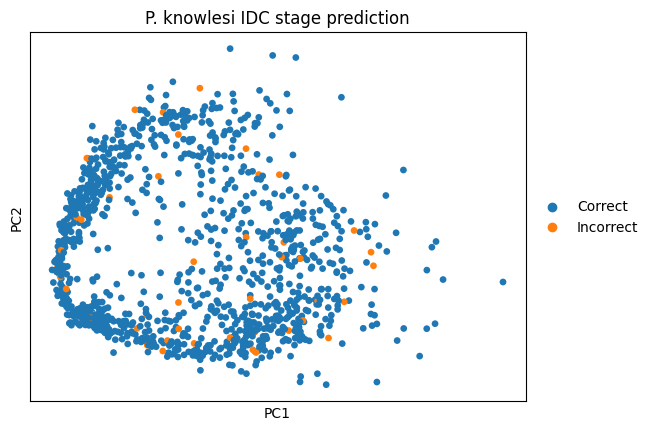

In [45]:
adata_test = adata[adata.obs["test_train"] == "Test",:]

# # compare prediction vs. original
def compareList(l1, l2):
    return ["Correct" if i==j else "Incorrect" for i, j in zip(l1, l2)]
prediction_label = compareList(predictions_test,original_class_test)
adata_test.obs['prediction'] = prediction_label
sc.pl.pca(adata_test,
          color="prediction",
          save='_Pk_prediction.png',
          title = 'P. knowlesi IDC stage prediction')

In [50]:
# Feature Selection
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV
original_class_factor = pd.factorize(PC_file.bulk.values.tolist(),sort=True)
log_trans_df = pd.DataFrame(log_trans_node_feat,index=list(counts_sanger.index.values),columns=gene_IDs)
X_train, X_test, y_train, y_test = train_test_split(log_trans_df,
                                                    original_class_factor[0],
                                                    test_size=test_ratio,
                                                    random_state=42)
# Train the model
e_net = ElasticNetCV(random_state=0,max_iter=1000)

# Define the hyperparameter search space
params = {
    # search alpha in log space
    'alphas': np.logspace(-5, 1, 10),
    # search from 0 to 1 by 0.1
    'l1_ratio': np.linspace(0, 1, 11)
}

# search the parameter space
grid_search = GridSearchCV(e_net, params, cv=5, n_jobs=-1)

# fit the model
grid_search.fit(log_trans_df, original_class_factor[0])

# find the best model
#best_elastic_net = grid_search.best_estimator_
grid_search.best_params_
abs(grid_search.best_score_)

/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.937e-01, tolerance: 2.032e-01
  model = cd_fast.enet_coordinate_descent(
/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.302e-01, tolerance: 2.032e-01
  model = cd_fast.enet_coordinate_descent(
/Users/seanconne

KeyboardInterrupt: 

In [ ]:

# # calculate the prediction and mean square error
# y_pred_elastic = e_net.predict(X_test)
# mean_squared_error = np.mean((y_pred_elastic - y_test)**2)
# print("Mean Squared Error on test set", mean_squared_error)
#
# e_net_coeff = pd.DataFrame()
# e_net_coeff["Columns"] = X_train.columns
# e_net_coeff['Coefficient Estimate'] = pd.Series(e_net.coef_)
# #e_net_coeff
#
# #elastic_net = ElasticNet(max_iter=10000, random_state=42)
# # parameters = {
# #     "alpha": np.logspace(-5, 2, 10),
# #     "l1_ratio": np.linspace(0,0.1,0.9,10)
# # }
# selected_features = []
# for i, coef in enumerate(e_net.coef_):
#     if coef != 0:
#         selected_features.append(log_trans_df.columns[i])
#
# print("Selected features:")
# print(selected_features)

In [40]:
 #print(log_trans_df.values[:, :-1])
#print(log_trans_df.values[:, -1])
print(grid_search.best_params_)

[1.00000000e-05 4.64158883e-05 2.15443469e-04 1.00000000e-03
 4.64158883e-03 2.15443469e-02 1.00000000e-01 4.64158883e-01
 2.15443469e+00 1.00000000e+01]


In [27]:
# Correct&Smooth
# adjancency matrix
adj = dataset[0].a

# label matrix
y = dataset[0].y

In [38]:
#import torch
#import torch_geometric
#import torch_sparse
#X = tf.convert_to_tensor()
# weighted adj matrix
A = adj_COO.A
# diagonal
D = np.diag(np.sum(A, axis=1))
# inverse square root
D_inv_sqrt = scipy.linalg.fractional_matrix_power(D,-0.5)
# normalized matrix
S = D_inv_sqrt @ A @ D_inv_sqrt

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.04263757
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

In [69]:
# load single cell data from
df_snakemake = pd.read_csv('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/data/Concatenated_Pk_gene_exon_dge.txt',sep="\t")

In [70]:
df_snakemake = df_snakemake.set_index('GENE')

In [71]:
df_snakemake = df_snakemake.transpose()

In [72]:
df_snakemake.index.names = ['Cell']
df_snakemake.columns.names = ['Gene']

In [85]:
# make a function (don't be lazy lol)
# initalize dictionary
gff_dict = {new_list: [] for new_list in df_snakemake.columns}
with open('/Users/seanconnelly/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/UNC/Graduate_School/COMP_790/SC_Project/snakemake_SC_pipeline/metadata/PlasmoDB-61_PknowlesiA1H1.gff') as annotation_f:
    for gff_line in annotation_f:
        clean_gff_line = gff_line.strip()
        # don't forget about header (##)
        if '##' not in clean_gff_line:
            clean_gff_list = clean_gff_line.split('\t')
            # Store the gene ID in the Parent entry in each accession
            ID = clean_gff_list[8].split(';')[1][7:]
            #print(ID)
            # only store genes in the file and with an empty list
            if ID in gff_dict.keys() and gff_dict[ID] == []:
                # Find the index that begins the gene name
                start_of_name = gff_line.find('description') + 12
                #Store the gene name in the variable description
                description = gff_line[start_of_name:].split(';')[0]
                # If there is a space, replace it with an underscore
                if ' ' in description:
                    # Replace the space with an underscore
                    name_nowt = description.replace(' ', '_')
                    # Replace the ACII code for a comma with a blank string and replace - with an underscore
                    if '%2C' in description or '-' in description or '/' in description or '(' in description or ')' in description or '[' in description or ']' in description or "'" in description or "+" in description:
                        name_nocomma = name_nowt.replace('%2C', '')
                        name_nounder = name_nocomma.replace('-', '_')
                        name_nopara = name_nounder.replace('(', '_')
                        name_nopara2 = name_nopara.replace(')', '_')
                        name_nobracket = name_nopara2.replace('[', '_')
                        name_nobracket2 = name_nobracket.replace(']', '_')
                        name_noapo = name_nobracket2.replace("'", '_')
                        name_noplus = name_noapo.replace("+", "plus")
                        name = name_noplus.replace('/', '_')
                    # If the name does not have those characters, then store name
                    else:
                        name = name_nowt
                gff_dict[ID].append(name)
gene_IDs = []
for a in df_snakemake.columns:
     gene_IDs.append(
        {
            'PK_ID': a,
            'Gene': ''.join(gff_dict[a]),
        }
    )
gene_IDs = pd.DataFrame(gene_IDs)

In [87]:
print(gene_IDs)

                PK_ID                                               Gene
0     PKA1H_000005000                     cytochrome_c_oxidase_subunit_3
1     PKA1H_000005100                     cytochrome_c_oxidase_subunit_I
2     PKA1H_000005200                                       cytochrome_b
3     PKA1H_000006200           apicoplast_ribosomal_protein_S4_putative
4     PKA1H_000007500                      ribosomal_protein_S3_putative
...               ...                                                ...
5232  PKA1H_140079200       Plasmodium_exported_protein_unknown_function
5233  PKA1H_140079400       Plasmodium_exported_protein_unknown_function
5234  PKA1H_140079500  Plasmodium_exported_protein__PHIST__unknown_fu...
5235  PKA1H_140079600                                     SICAvar_type_I
5236  PKA1H_140079700                                     SICAvar_type_I

[5237 rows x 2 columns]


In [89]:
# load the cell by gene matrix
adata_snake = sc.AnnData(df_snakemake,
    df_snakemake.index.to_frame(),
    df_snakemake.columns.to_frame())
# add
adata_snake.var['gene_symbols'] = gene_IDs['Gene'].tolist()
adata_snake.var_names = adata_snake.var['gene_symbols']
# make names unique
adata_snake.var_names_make_unique(join='')

/var/folders/b3/_d0b62ts645bnlhb2xdb86xm0000gn/T/ipykernel_62674/991192561.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_snake = sc.AnnData(df_snakemake,


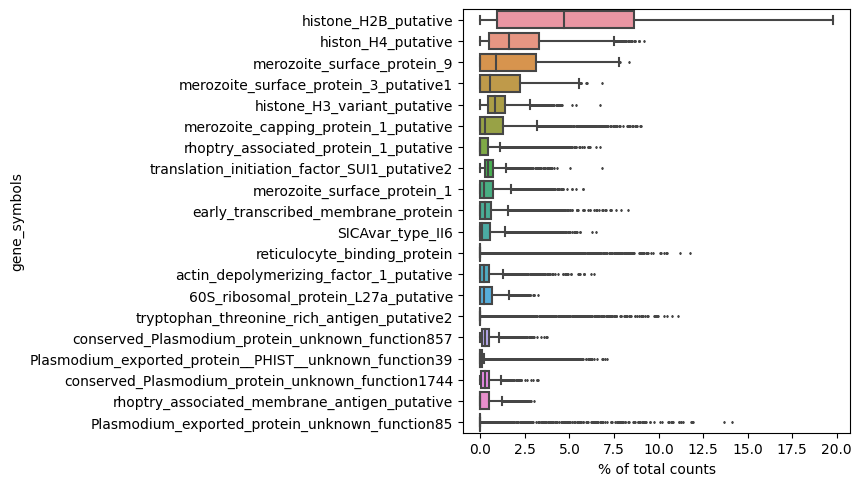

In [90]:
sc.pl.highest_expr_genes(adata_snake, n_top=20, )

In [19]:
# CellRank
import scvelo as scv
import cellrank as cr
adata

AnnData object with n_obs × n_vars = 4237 × 5192
    obs: 'Cells', 'cell_type'
    var: 'Genes', 'gene_symbols'
    uns: 'log1p', 'pca', 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

AxisError: axis 1 is out of bounds for array of dimension 1

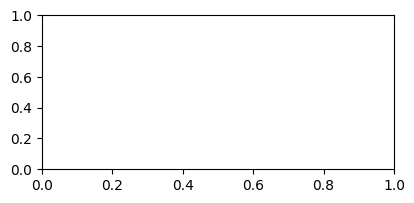